# Setup

Original Reference: https://colab.research.google.com/gist/virattt/251cfea5e66b21c7b6a58b8952476117/hedge-fund-trading-team.ipynb#scrollTo=ro6_juA_nHl-

In [14]:
import getpass
from dotenv import load_dotenv
import pandas as pd
# import requests
import os
from datetime import timedelta
import matplotlib.pyplot as plt
import json

from openbb import obb

# Import your agent's dependencies
from langchain_openai.chat_models import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessagesState, StateGraph, START
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


In [15]:
load_dotenv()

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")               # For calling LLM. Get from https://platform.openai.com/
# _set_if_undefined("FINANCIAL_DATASETS_API_KEY")   # For getting financial data. Get from https://financialdatasets.ai

In [16]:
# We use GPT-4o, but you can use any LLM
llm = ChatOpenAI(model="gpt-4o")
# llama3.2:1b very fast but not accurate
# llama3.1 very slow
# llama3.2 faster than 3.1
# mistral gemma qwen gemma2
# llm = ChatOllama(model="llama3.2") 

# Create Market Data Agent

In [17]:
def market_data_agent(state: MessagesState):
    """Responsible for gathering and preprocessing market data"""
    messages = state["messages"]
    params = messages[-1].additional_kwargs

    # Get the historical price data
    historical_data = get_price_data(
        params["ticker"], params["start_date"], params["end_date"]
    )

    # Calculate the trading signals
    signals = calculate_trading_signals(historical_data)

    # Create the market data agent's message using the signals and historical data
    message = HumanMessage(
        content=f"""
        Here are the trading signals for {params["ticker"]}:
        Current Price: ${signals['current_price']:.2f}
        SMA 5: {signals['sma_5_curr']:.2f}
        SMA 5 Previous: {signals['sma_5_prev']:.2f}
        SMA 20: {signals['sma_20_curr']:.2f}
        SMA 20 Previous: {signals['sma_20_prev']:.2f}
        Volume: {signals['volume']:.2f}
        """,
        name="market_data_agent",
    )

    return {"messages": messages + [message]}

# Create Quant Agent

In [18]:
def quant_agent(state: MessagesState):
    """Analyzes technical indicators and generates trading signals"""
    last_message = state["messages"][-1]

    summary_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are a hedge fund quant / technical analyst.
                You are given trading signals for a stock.
                Analyze the signals and provide a recommendation.
                - signal: bullish | bearish | neutral,
                - confidence: <float between 0 and 1>
                """
            ),
            MessagesPlaceholder(variable_name="messages"),
            (
                "human",
                f"""Based on the trading signals below, analyze the data and provide your assessment.

                Trading Analysis: {last_message.content}

                Only include your trading signal and confidence in the output.
                """
            ),
        ]
    )

    chain = summary_prompt | llm

    result = chain.invoke(state).content
    message = HumanMessage(
        content=f"Here is the trading analysis and my recommendation:{result}",
        name="quant_agent",
    )

    return {"messages": state["messages"] + [message]}

# Create Risk Management Agent

In [19]:
def risk_management_agent(state: MessagesState):
    """Evaluates portfolio risk and sets position limits"""
    portfolio = state["messages"][0].additional_kwargs["portfolio"]
    last_message = state["messages"][-1]

    risk_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are a risk management specialist.
                Your job is to take a look at the trading analysis and
                evaluate portfolio exposure and recommend position sizing.
                Provide the following in your output (not as a JSON):
                - max_position_size: <float greater than 0>,
                - risk_score: <integer between 1 and 10>"""
            ),
            MessagesPlaceholder(variable_name="messages"),
            (
                "human",
                f"""Based on the trading analysis below, provide your risk assessment.

                Trading Analysis: {last_message.content}

                Here is the current portfolio:
                Portfolio:
                Cash: ${portfolio['cash']:.2f}
                Current Position: {portfolio['stock']} shares

                Only include the max position size and risk score in your output.
                """
            ),
        ]
    )
    chain = risk_prompt | llm
    result = chain.invoke(state).content
    message = HumanMessage(
        content=f"Here is the risk management recommendation: {result}",
        name="risk_management",
    )
    return {"messages": state["messages"] + [message]}

# Create Portfolio Management Agent

In [20]:
def portfolio_management_agent(state: MessagesState):
    """Makes final trading decisions and generates orders"""
    portfolio = state["messages"][0].additional_kwargs["portfolio"]
    last_message = state["messages"][-1]

    portfolio_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are a portfolio manager making final trading decisions.
                Your job is to make a trading decision based on the risk management data.
                Provide the following in your output:
                - "action": "buy" | "sell" | "hold",
                - "quantity": <positive integer>
                Only buy if you have available cash.
                The quantity that you buy must be less than or equal to the max position size.
                Only sell if you have shares in the portfolio to sell.
                The quantity that you sell must be less than or equal to the current position."""
            ),
            MessagesPlaceholder(variable_name="messages"),
            (
                "human",
                f"""Based on the risk management data below, make your trading decision.

                Risk Management Data: {last_message.content}

                Here is the current portfolio:
                Portfolio:
                Cash: ${portfolio['cash']:.2f}
                Current Position: {portfolio['stock']} shares

                Only include the action and quantity.

                Remember, the action must be either buy, sell, or hold.
                You can only buy if you have available cash.
                You can only sell if you have shares in the portfolio to sell.
                """
            ),
        ]
    )

    chain = portfolio_prompt | llm
    result = chain.invoke(state).content
    return {"messages": [HumanMessage(content=result, name="portfolio_management")]}

# Create Agent Graph

In [21]:
# Define the new workflow
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("market_data_agent", market_data_agent)
workflow.add_node("quant_agent", quant_agent)
workflow.add_node("risk_management_agent", risk_management_agent)
workflow.add_node("portfolio_management_agent", portfolio_management_agent)

# Define the workflow
workflow.add_edge(START, "market_data_agent")
workflow.add_edge("market_data_agent", "quant_agent")
workflow.add_edge("quant_agent", "risk_management_agent")
workflow.add_edge("risk_management_agent", "portfolio_management_agent")
workflow.add_edge("portfolio_management_agent", END)

app = workflow.compile()

In [22]:
# Update the run_agent function to include portfolio state
def run_agent(ticker: str, start_date: str, end_date: str, portfolio: dict):
    final_state = app.invoke(
        {
            "messages": [
                HumanMessage(
                    content="Make a trading decision based on the provided data.",
                    additional_kwargs={
                        "ticker": ticker,
                        "start_date": start_date,
                        "end_date": end_date,
                        "portfolio": portfolio
                    },
                )
            ]
        },
        config={"configurable": {"thread_id": 42}},
    )
    return final_state["messages"][-1].content

# Get Stock Price and Trading Signals

In [23]:
# Define a function to calculate trading signals
def calculate_trading_signals(historical_data: pd.DataFrame) -> dict:
    """Calculate trading signals based on SMA crossover strategy"""
    # Calculate SMAs
    sma_5 = historical_data["close"].rolling(window=5).mean()
    sma_20 = historical_data["close"].rolling(window=20).mean()

    # Get the last two points of each SMA to check for crossover
    sma_5_prev, sma_5_curr = sma_5.iloc[-2:]
    sma_20_prev, sma_20_curr = sma_20.iloc[-2:]

    return {
        "current_price": historical_data["close"].iloc[-1],
        "sma_5_curr": sma_5_curr,
        "sma_5_prev": sma_5_prev,
        "sma_20_curr": sma_20_curr,
        "sma_20_prev": sma_20_prev,
        "volume": historical_data["volume"].iloc[-1],
    }

In [24]:
# obb.account.login(pat=os.environ.get("OPENBB_PAT"))

# Move the price data fetching function into the agent's scope
def get_price_data(ticker, start_date, end_date):
    df = obb.equity.price.historical(ticker, start_date, end_date, provider='yfinance').to_dataframe()

    return df

# Create Backtester

In [25]:
class Backtester:
    def __init__(self, agent, ticker, start_date, end_date, initial_capital):
        self.agent = agent
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.initial_capital = initial_capital
        self.portfolio = {"cash": initial_capital, "stock": 0}
        self.portfolio_values = []

    def parse_action(self, agent_output):
        try:
            # Expect JSON output from agent
            decision = json.loads("{" + agent_output + "}")
            return decision["action"], decision["quantity"]
        except:
            return "hold", 0

    def execute_trade(self, action, quantity, current_price):
        """Validate and execute trades based on portfolio constraints"""
        if action == "buy" and quantity > 0:
            cost = quantity * current_price
            if cost <= self.portfolio["cash"]:
                self.portfolio["stock"] += quantity
                self.portfolio["cash"] -= cost
                return quantity
            else:
                # Calculate maximum affordable quantity
                max_quantity = self.portfolio["cash"] // current_price
                if max_quantity > 0:
                    self.portfolio["stock"] += max_quantity
                    self.portfolio["cash"] -= max_quantity * current_price
                    return max_quantity
                return 0
        elif action == "sell" and quantity > 0:
            quantity = min(quantity, self.portfolio["stock"])
            if quantity > 0:
                self.portfolio["cash"] += quantity * current_price
                self.portfolio["stock"] -= quantity
                return quantity
            return 0
        return 0

    def run_backtest(self):
        dates = pd.date_range(self.start_date, self.end_date, freq="B")

        print("\nStarting backtest...")
        print(f"{'Date':<12} {'Action':<6} {'Quantity':>8} {'Price':>8} {'Cash':>12} {'Stock':>8} {'Total Value':>12}")
        print("-" * 70)

        for current_date in dates:
            lookback_start = (current_date - timedelta(days=30)).strftime("%Y-%m-%d")
            current_date_str = current_date.strftime("%Y-%m-%d")

            agent_output = self.agent(
                ticker=self.ticker,
                start_date=lookback_start,
                end_date=current_date_str,
                portfolio=self.portfolio
            )
            action, quantity = self.parse_action(agent_output)
            df = get_price_data(self.ticker, lookback_start, current_date_str)
            current_price = df.iloc[-1]['close']

            # Execute the trade with validation
            executed_quantity = self.execute_trade(action, quantity, current_price)

            # Update total portfolio value
            total_value = self.portfolio["cash"] + self.portfolio["stock"] * current_price
            self.portfolio["portfolio_value"] = total_value

            # Log the current state with executed quantity
            print(
                f"{current_date.strftime('%Y-%m-%d'):<12} {action:<6} {executed_quantity:>8} {current_price:>8.2f} "
                f"{self.portfolio['cash']:>12.2f} {self.portfolio['stock']:>8} {total_value:>12.2f}"
            )

            # Record the portfolio value
            self.portfolio_values.append(
                {"Date": current_date, "Portfolio Value": total_value}
            )

    def analyze_performance(self):
        # Convert portfolio values to DataFrame
        performance_df = pd.DataFrame(self.portfolio_values).set_index("Date")

        # Calculate total return
        total_return = (
                           self.portfolio["portfolio_value"] - self.initial_capital
                       ) / self.initial_capital
        print(f"Total Return: {total_return * 100:.2f}%")

        # Plot the portfolio value over time
        performance_df["Portfolio Value"].plot(
            title="Portfolio Value Over Time", figsize=(12, 6)
        )
        plt.ylabel("Portfolio Value ($)")
        plt.xlabel("Date")
        plt.show()

        # Compute daily returns
        performance_df["Daily Return"] = performance_df["Portfolio Value"].pct_change()

        # Calculate Sharpe Ratio (assuming 252 trading days in a year)
        mean_daily_return = performance_df["Daily Return"].mean()
        std_daily_return = performance_df["Daily Return"].std()
        sharpe_ratio = (mean_daily_return / std_daily_return) * (252 ** 0.5)
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

        # Calculate Maximum Drawdown
        rolling_max = performance_df["Portfolio Value"].cummax()
        drawdown = performance_df["Portfolio Value"] / rolling_max - 1
        max_drawdown = drawdown.min()
        print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

        return performance_df

# Run the Backtest


Starting backtest...
Date         Action Quantity    Price         Cash    Stock  Total Value
----------------------------------------------------------------------
2024-10-01   buy       20000     2.20     56000.00    20000    100000.00
2024-10-02   hold          0     2.22     56000.00    20000    100400.00
2024-10-03   sell      10000     2.21     78100.00    10000    100200.00
2024-10-04   hold          0     2.20     78100.00    10000    100100.00
2024-10-07   hold          0     2.30     78100.00    10000    101100.00
2024-10-08   sell       5000     2.10     88600.00     5000     99100.00
2024-10-09   sell        500     2.03     89615.00     4500     98750.00
2024-10-10   sell       2000     2.14     93905.00     2500     99267.50
2024-10-11   sell       1500     2.05     96980.00     1000     99030.00
2024-10-14   sell        500     2.09     98025.00      500     99070.00
2024-10-15   sell        500     2.06     99055.00        0     99055.00
2024-10-16   hold          0   

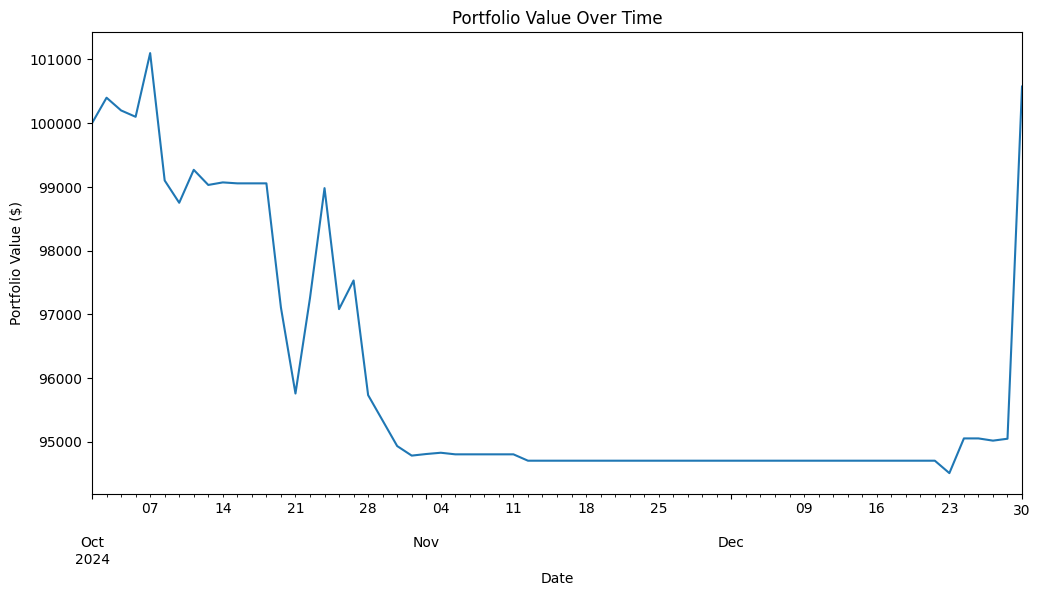

Sharpe Ratio: 0.22
Maximum Drawdown: -6.52%


In [26]:
# Define parameters
ticker = "AERT"  # Example ticker symbol
start_date = "2024-10-01"  # Adjust as needed
end_date = "2024-12-30"  # Adjust as needed
initial_capital = 100000  # $100,000

# Create an instance of Backtester
backtester = Backtester(
    agent=run_agent,
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    initial_capital=initial_capital,
)

# Run the backtesting process
backtester.run_backtest()
performance_df = backtester.analyze_performance()